In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import pandas as pd
import numpy as np

import sys 
sys.path.append("../..") 
import os
%aimport preprocessing
%aimport utils
%aimport p2v

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import kendalltau
from collections import defaultdict

from utils import prinT

import seaborn as sns
from matplotlib import pyplot as plt

pd.options.display.max_columns = None
pd.set_option('max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
model = p2v.P2V()
d=100
w=10

2024-03-31 22:36:31 -- start loading Mag_venue_info_df
2024-03-31 22:36:31 -- finish.
2024-03-31 22:36:31 -- start loading labeled_journal_info_df
2024-03-31 22:36:31 -- finish.


**tracking Cognitive Science**

Cognitive Science
78735424

In [4]:
def default_value():
    return 0


def count_paper_num_for_subarea(VID):
    dict_list = []
    for i in range(len(model.start_year_list)-5, len(model.start_year_list)):
        start_year=model.start_year_list[i]
        end_year=model.end_year_list[i]
        prinT("start searching in %s to %s" %(start_year, end_year))

        model.load_paper_df(full_load=False, start_year=start_year, end_year=end_year)
        model.load_ref_df(full_load=False, start_year=start_year, end_year=end_year)
        VID_labeled = model.load_VID_labeled(start_year, end_year, d, w)
        VID_labeled_df = pd.DataFrame(VID_labeled)
        VID_labeled_df.set_index('VID', inplace=True)

        journal_df = model.target_paper_df[model.target_paper_df.VenueID == VID]
        journal_ref_df = pd.merge(journal_df, model.target_ref_df, left_on='PaperID', right_on='PaperID')
        journal_ref_df = pd.merge(journal_ref_df, model.target_paper_df, left_on='PaperReferenceID', right_on='PaperID')
        journal_ref_df.drop(columns=['PaperReferenceID'], inplace=True)
        journal_ref_df = pd.merge(journal_ref_df, VID_labeled_df, left_on='VenueID_y', right_index=True)

        journal_ref_df.drop(journal_ref_df[
                            (journal_ref_df['subarea_label'].str.contains('General'))|
                            (journal_ref_df['subarea_label'].str.contains('miscellaneous'))|
                            (journal_ref_df['subarea_label']=='Multidisciplinary')].index, 
                            inplace=True)

        subarea_paper_count = defaultdict(default_value)
        for row in journal_ref_df.groupby(['PaperID_x'])['subarea_label'].agg(pd.Series.mode):
            if type(row) == str:
                subarea_paper_count[row] = subarea_paper_count[row] + 1
            if type(row) == np.ndarray:
                subarea_num = len(row)
                for subarea in row:
                    subarea_paper_count[subarea] = subarea_paper_count[subarea] + 1/subarea_num
        dict_list.append(dict(subarea_paper_count))
    count_df = pd.DataFrame(dict_list).T
    count_df.columns = ['1970s', '1980s', '1990s', '2000s', '2010s']
    count_df['sum']=count_df.sum(axis=1)
    count_df.reset_index(inplace=True)
    count_df = count_df.sort_values("sum", ascending=False)
    count_df_up = count_df.iloc[:7]
    count_df_full = pd.concat([count_df_up, pd.DataFrame({'index': 'others', 
                                                          '1970s': count_df['1970s'].iloc[10:].sum(), 
                                                          '1980s': count_df['1980s'].iloc[10:].sum(), 
                                                          '1990s': count_df['1990s'].iloc[10:].sum(), 
                                                          '2000s': count_df['2000s'].iloc[10:].sum(), 
                                                          '2010s': count_df['2010s'].iloc[10:].sum(), 
                                                          'sum': count_df['sum'].iloc[7:].sum()}, 
                                                         index=[0])], 
                              ignore_index=True)
    count_df_full['1970s'] = (count_df_full['1970s']/count_df_full['1970s'].sum()) * 100
    count_df_full['1980s'] = (count_df_full['1980s']/count_df_full['1980s'].sum()) * 100
    count_df_full['1990s'] = (count_df_full['1990s']/count_df_full['1990s'].sum()) * 100
    count_df_full['2000s'] = (count_df_full['2000s']/count_df_full['2000s'].sum()) * 100
    count_df_full['2010s'] = (count_df_full['2010s']/count_df_full['2010s'].sum()) * 100
    count_df_full.set_index('index', inplace=True)
    count_df_full.index.rename('decade', inplace=True)
    count_df_full.drop('sum', axis=1, inplace=True)

    return count_df_full.T


def cal_subarea_avg_cs(target_VID: int):
    cs_data = []
    for i in range(len(model.start_year_list)-5, len(model.start_year_list)):
        model.load_wv(model.start_year_list[i], model.end_year_list[i], d, w)
        target_journal_vector = model.wv.get_vector(target_VID, norm=True)
        full_vector_list = model.wv.get_normed_vectors()

        VID_labeled = model.load_VID_labeled(model.start_year_list[i], model.end_year_list[i], d, w)
        label_list = VID_labeled['subarea_label']
        labeled_VID_list = VID_labeled['VID']
        labeled_vector_list = np.stack([model.wv.get_vector(VID, norm=True) for VID in labeled_VID_list])

        single_decade_data = {}
        subareas = list(set(label_list))
        for subarea in subareas:
            single_subarea_idx_list = [idx for idx, label in list(enumerate(label_list)) if label == subarea]
            single_subarea_cs = cosine_similarity(target_journal_vector.reshape(1, -1), labeled_vector_list[single_subarea_idx_list])
            general_cs = cosine_similarity(target_journal_vector.reshape(1, -1), full_vector_list)
            
            single_decade_data[subarea] = np.mean((single_subarea_cs))/np.mean(general_cs)
        cs_data.append(single_decade_data)
    cs_df = pd.DataFrame(cs_data).T
    cs_df.columns = ['1970s', '1980s', '1990s', '2000s', '2010s']
    cs_df['sum']=cs_df.sum(axis=1)
    cs_df = cs_df.sort_values("sum", ascending=False)
    cs_df.index.rename('decade', inplace=True)
    cs_df.drop('sum', axis=1, inplace=True)

    return cs_df.T

def cal_jnl_cs(center_vname: str, venue_name_list: list):
    center_VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==center_vname].index[0]
    jnl_cs_df = pd.DataFrame(columns=venue_name_list)
    
    for i, start_year in enumerate(start_year_list):
        end_year = end_year_list[i]
        wv = model.load_wv(start_year, end_year, d, w)
        
        for venue_name in venue_name_list:
            VID = model.MAG_venue_info_df[model.MAG_venue_info_df.OriginalVenue==venue_name].index[0]
            try:
                sim = wv.similarity(center_VID, VID)
                jnl_cs_df.loc[str(start_year)+'s', venue_name] = sim
            except KeyError:
                jnl_cs_df.loc[str(start_year)+'s', venue_name] = np.nan
    return jnl_cs_df

In [5]:
count_df = count_paper_num_for_subarea(78735424)

2024-03-31 22:36:40 -- start searching in 1970 to 1979
2024-03-31 22:36:40 -- start loading 'paper_df'...
2024-03-31 22:36:40 -- finish.
2024-03-31 22:36:40 -- start loading 'ref_df'...
2024-03-31 22:36:41 -- finish.
2024-03-31 22:36:41 -- start loading VID_labeled...
2024-03-31 22:36:41 -- finish.
2024-03-31 22:36:42 -- start searching in 1980 to 1989
2024-03-31 22:36:42 -- start loading 'paper_df'...
2024-03-31 22:36:43 -- finish.
2024-03-31 22:36:43 -- start loading 'ref_df'...
2024-03-31 22:36:43 -- finish.
2024-03-31 22:36:43 -- start loading VID_labeled...
2024-03-31 22:36:43 -- finish.
2024-03-31 22:36:46 -- start searching in 1990 to 1999
2024-03-31 22:36:46 -- start loading 'paper_df'...
2024-03-31 22:36:47 -- finish.
2024-03-31 22:36:47 -- start loading 'ref_df'...
2024-03-31 22:36:48 -- finish.
2024-03-31 22:36:48 -- start loading VID_labeled...
2024-03-31 22:36:48 -- finish.
2024-03-31 22:36:53 -- start searching in 2000 to 2009
2024-03-31 22:36:53 -- start loading 'paper_d

In [6]:
count_df

decade,Experimental and Cognitive Psychology,Linguistics and Language,Developmental and Educational Psychology,Artificial Intelligence,Cognitive Neuroscience,Education,Philosophy,others
1970s,9.868421,42.763158,NaN,31.359649,NaN,4.824561,4.166667,7.017544
1980s,17.509025,19.795427,0.902527,44.524669,NaN,4.392298,4.211793,8.664260
1990s,27.258567,11.682243,1.401869,36.033229,2.492212,7.788162,2.699896,10.643821
2000s,62.333545,12.623426,4.982335,2.047287,3.940574,2.989401,2.137875,8.945557
2010s,63.460839,9.653007,6.927049,1.436302,3.623182,3.154329,2.451669,9.293622


In [7]:
cs_df = cal_subarea_avg_cs(78735424)

2024-03-31 22:39:20 -- start loading word vectors...
2024-03-31 22:39:20 -- word vectors loaded, and its shape is: (5686, 100)
2024-03-31 22:39:20 -- start loading VID_labeled...
2024-03-31 22:39:20 -- finish.
2024-03-31 22:39:21 -- start loading word vectors...
2024-03-31 22:39:21 -- word vectors loaded, and its shape is: (9337, 100)
2024-03-31 22:39:21 -- start loading VID_labeled...
2024-03-31 22:39:21 -- finish.
2024-03-31 22:39:22 -- start loading word vectors...
2024-03-31 22:39:22 -- word vectors loaded, and its shape is: (15019, 100)
2024-03-31 22:39:22 -- start loading VID_labeled...
2024-03-31 22:39:22 -- finish.
2024-03-31 22:39:23 -- start loading word vectors...
2024-03-31 22:39:23 -- word vectors loaded, and its shape is: (27460, 100)
2024-03-31 22:39:23 -- start loading VID_labeled...
2024-03-31 22:39:23 -- finish.
2024-03-31 22:39:26 -- start loading word vectors...
2024-03-31 22:39:26 -- word vectors loaded, and its shape is: (37594, 100)
2024-03-31 22:39:26 -- start l

In [8]:
cs_df

decade,Experimental and Cognitive Psychology,Linguistics and Language,Artificial Intelligence,Language and Linguistics,Psychology (miscellaneous),Philosophy,General Psychology,Music,Social Psychology,Education,Developmental and Educational Psychology,Information Systems,Human-Computer Interaction,Computer Graphics and Computer-Aided Design,Software,Computational Theory and Mathematics,Control and Optimization,Logic,Neuropsychology and Physiological Psychology,Cognitive Neuroscience,Human Factors and Ergonomics,Communication,General Computer Science,Library and Information Sciences,Computer Science Applications,Literature and Literary Theory,Applied Psychology,Classics,Speech and Hearing,Theoretical Computer Science,Accounting,Computer Networks and Communications,Visual Arts and Performing Arts,General Arts and Humanities,Museology,Arts and Humanities (miscellaneous),Religious Studies,Organizational Behavior and Human Resource Management,Behavioral Neuroscience,Signal Processing,Strategy and Management,Cultural Studies,Clinical Psychology,Control and Systems Engineering,"Business, Management and Accounting (miscellaneous)",Marketing,General Social Sciences,Architecture,Occupational Therapy,Sensory Systems,Finance,Business and International Management,"Tourism, Leisure and Hospitality Management","General Business, Management and Accounting",Anthropology,Computers in Earth Sciences,Management Science and Operations Research,Social Sciences (miscellaneous),History and Philosophy of Science,Computational Mathematics,Industrial and Manufacturing Engineering,Sociology and Political Science,Hardware and Architecture,Archeology (arts and humanities),General Neuroscience,Health Informatics,Gender Studies,Transportation,Psychiatric Mental Health,History,Rehabilitation,Archeology,Information Systems and Management,Ecological Modeling,Law,"Economics, Econometrics and Finance (miscellaneous)",Modeling and Simulation,"Physical Therapy, Sports Therapy and Rehabilitation",Economics and Econometrics,Psychiatry and Mental Health,Management of Technology and Innovation,"General Economics, Econometrics and Finance",Political Science and International Relations,Nature and Landscape Conservation,Algebra and Number Theory,Public Administration,Electrical and Electronic Engineering,Discrete Mathematics and Combinatorics,Applied Mathematics,Computer Vision and Pattern Recognition,Geometry and Topology,Aerospace Engineering,Statistical and Nonlinear Physics,Leadership and Management,General Nursing,General Mathematics,Health (social science),Analysis,Biological Psychiatry,Management Information Systems,Neuroscience (miscellaneous),Astronomy and Astrophysics,Acoustics and Ultrasonics,Earth-Surface Processes,"Management, Monitoring, Policy and Law",Mathematical Physics,Civil and Structural Engineering,"Geography, Planning and Development",Orthodontics,Mathematics (miscellaneous),"Statistics, Probability and Uncertainty",Ocean Engineering,Industrial Relations,"Safety, Risk, Reliability and Quality",Urban Studies,Statistics and Probability,Earth and Planetary Sciences (miscellaneous),Pediatrics,Paleontology,Geophysics,Neurology,Demography,Development,General Engineering,"Ecology, Evolution, Behavior and Systematics",Media Technology,Mechanical Engineering,Ecology,General Earth and Planetary Sciences,General Decision Sciences,Space and Planetary Science,Atmospheric Science,Geriatrics and Gerontology,Geology,Health Policy,Global and Planetary Change,Automotive Engineering,Fluid Flow and Transfer Processes,Cellular and Molecular Neuroscience,Oceanography,Optometry,General Physics and Astronomy,Physics and Astronomy (miscellaneous),Conservation,Medicine (miscellaneous),Computer Science (miscellaneous),Nuclear and High Energy Physics,Neurology (clinical),General Health Professions,Geotechnical Engineering and Engineering Geology,"Atomic and Molecular Physics, and Optics",Endocrine and Autonomic Systems,General Environmental Science,"Electronic, Optical and Magn

In [21]:
start_year_list = [1970, 1980, 1990, 2000, 2010]
end_year_list = [1979, 1989, 1999, 2009, 2021]
venue_name_list = [
    'Journal of Experimental Psychology: General',
    'Philosophical Perspectives',
    'international joint conference on artificial intelligence',
    'meeting of the association for computational linguistics',
    'conference cognitive science',
]
jnl_cs_df = cal_jnl_cs('Cognitive Science', venue_name_list)
jnl_cs_df

2024-04-01 12:36:23 -- start loading word vectors...
2024-04-01 12:36:23 -- word vectors loaded, and its shape is: (5686, 100)
2024-04-01 12:36:23 -- start loading word vectors...
2024-04-01 12:36:23 -- word vectors loaded, and its shape is: (9337, 100)
2024-04-01 12:36:23 -- start loading word vectors...
2024-04-01 12:36:23 -- word vectors loaded, and its shape is: (15019, 100)
2024-04-01 12:36:23 -- start loading word vectors...
2024-04-01 12:36:23 -- word vectors loaded, and its shape is: (27460, 100)
2024-04-01 12:36:23 -- start loading word vectors...
2024-04-01 12:36:23 -- word vectors loaded, and its shape is: (37594, 100)


,Journal of Experimental Psychology: General,Philosophical Perspectives,international joint conference on artificial intelligence,meeting of the association for computational linguistics,conference cognitive science
1970s,0.680364,NaN,0.804869,0.908925,NaN
1980s,0.595486,0.545217,0.639004,0.622166,0.787923
1990s,0.478421,0.533898,0.534906,0.520716,0.703449
2000s,0.714945,0.524914,0.498977,0.57413,0.819929
2010s,0.803163,0.587758,0.545113,0.642192,0.88874


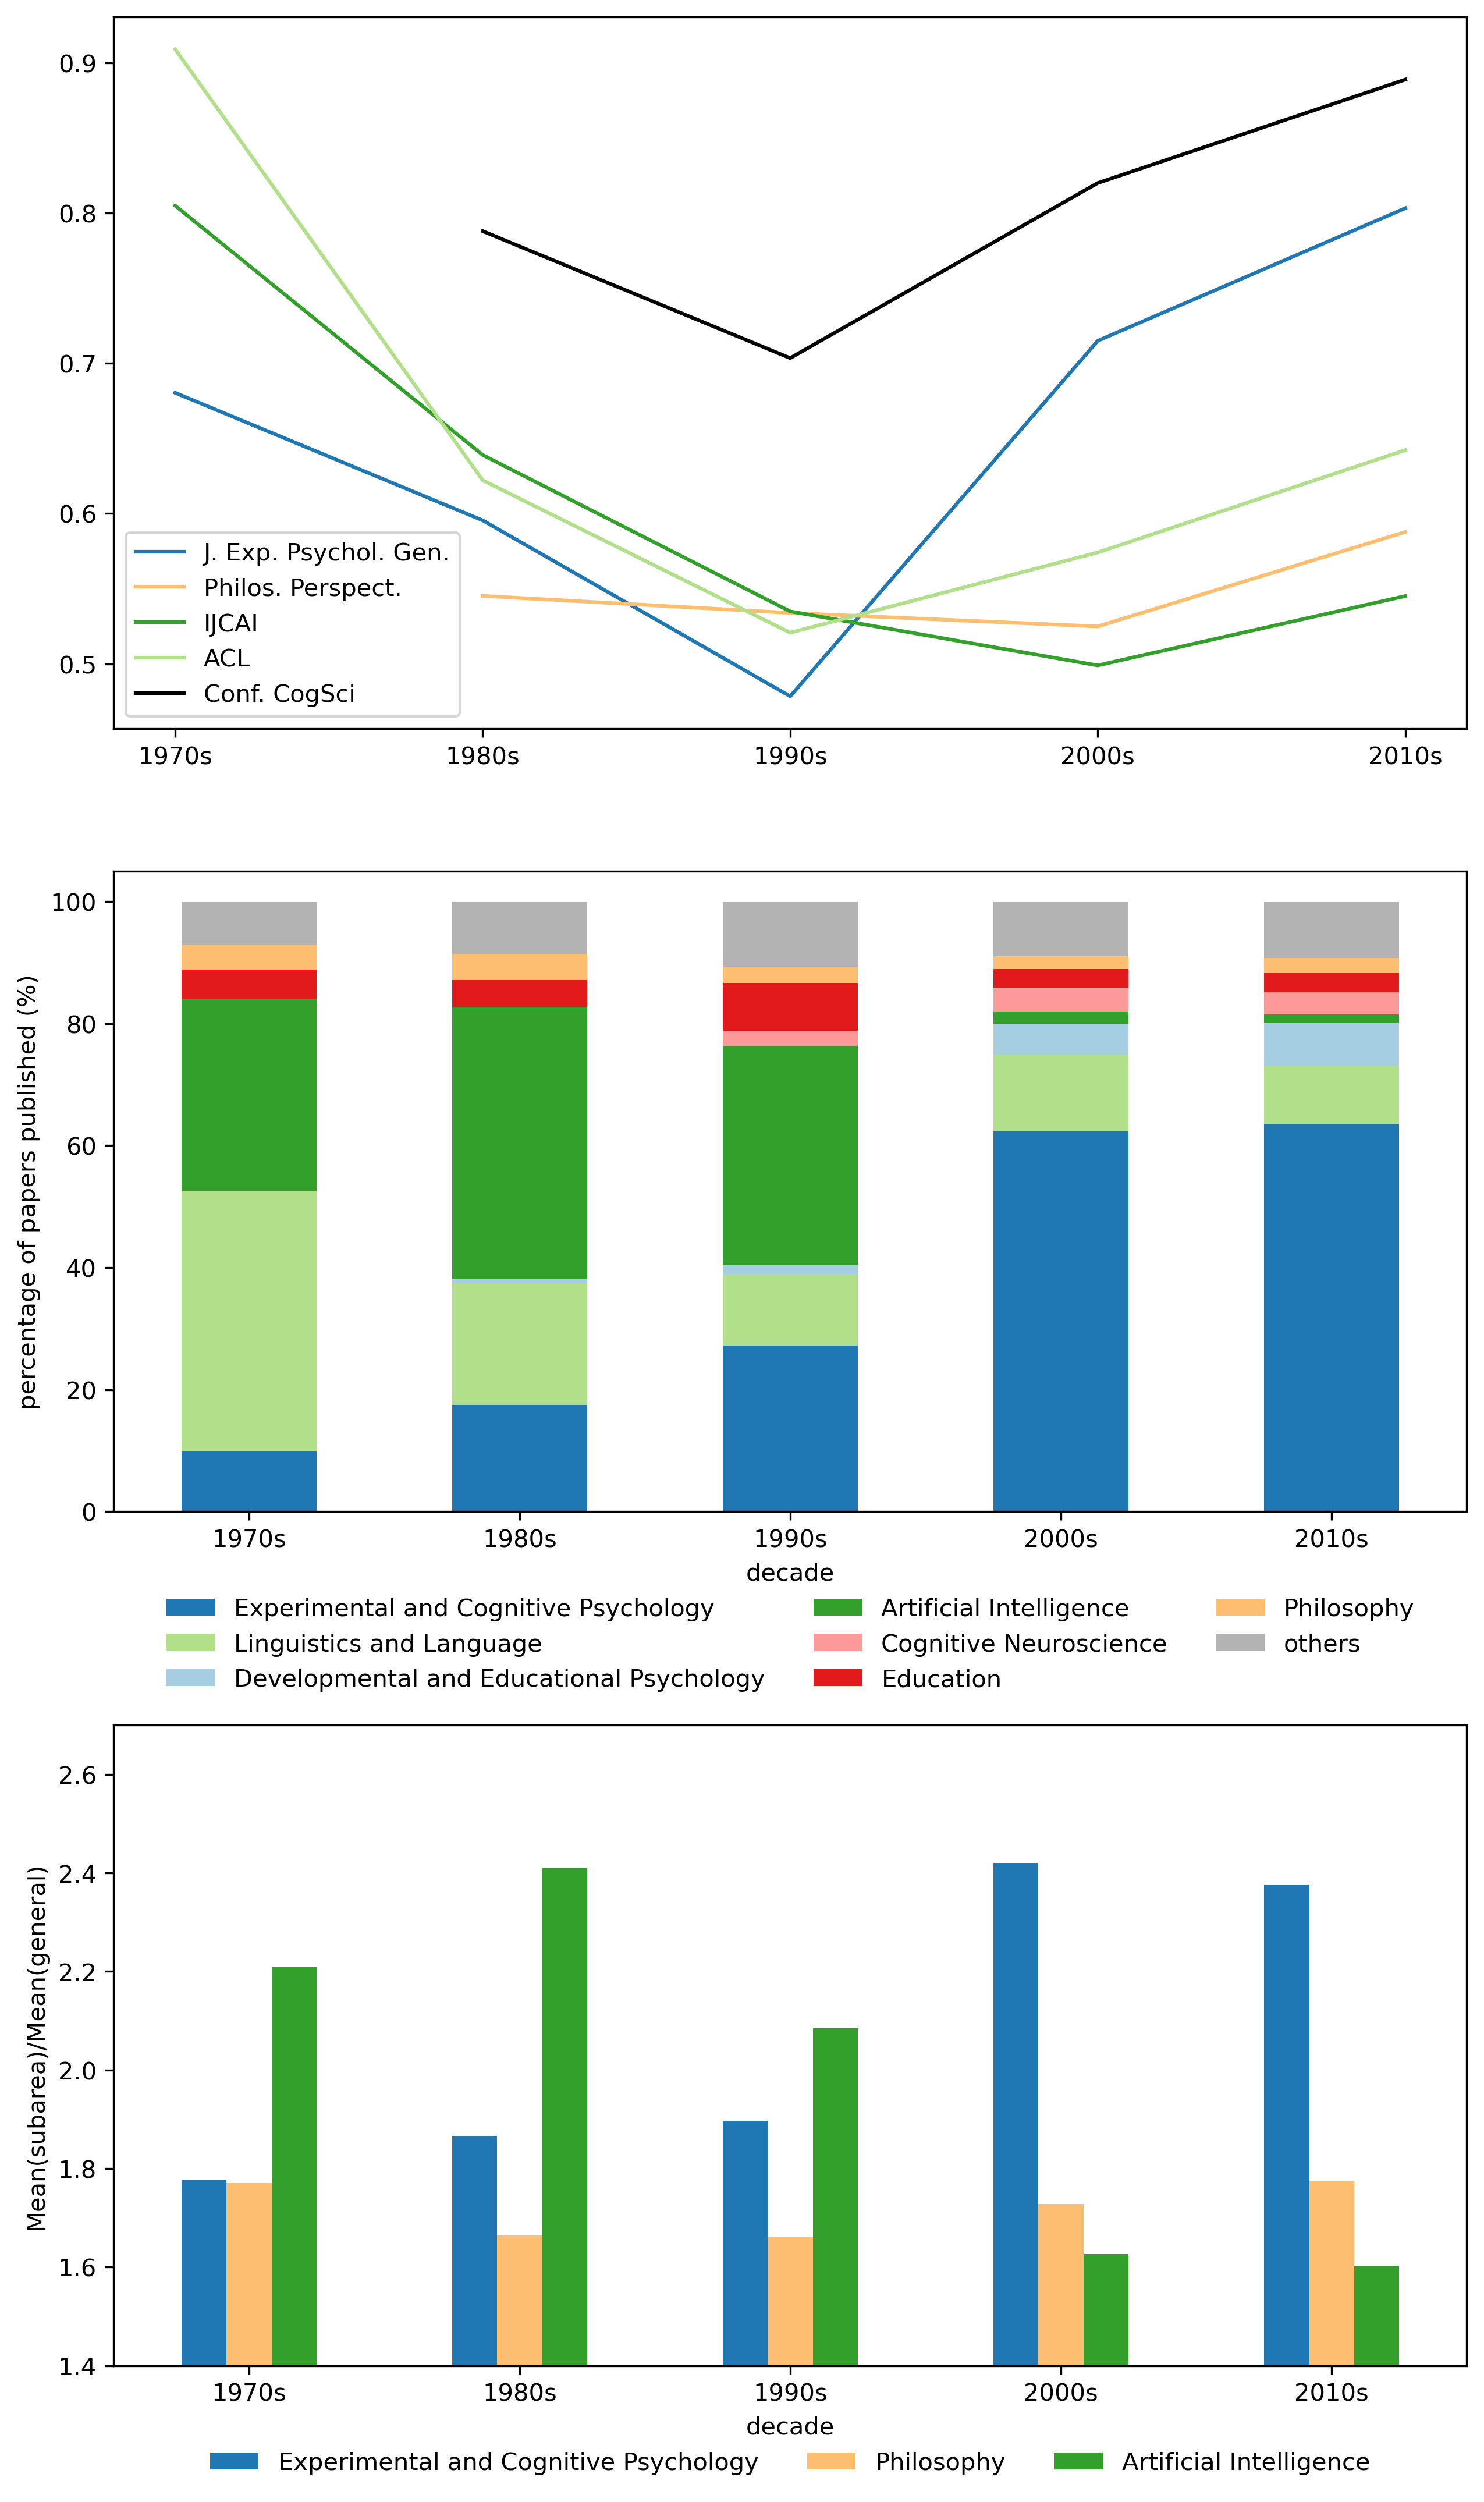

In [24]:
color_dict = {'Experimental and Cognitive Psychology': '#1f78b4', 
              'Linguistics and Language': '#b2df8a',	
              'Developmental and Educational Psychology': '#a6cee3',	
              'Artificial Intelligence': '#33a02c',	
              'Cognitive Neuroscience': '#fb9a99',
              'Education': '#e31a1c',	
              'Philosophy': '#fdbf6f',
              'others': '#b3b3b3'}

fig = plt.figure(figsize=(10,18), dpi=300)

plt.subplot(3,1,1)
jnl_color_dict = {
    'J. Exp. Psychol. Gen.': '#1f78b4',
    'Philos. Perspect.': '#fdbf6f',
    'IJCAI': '#33a02c',
    'ACL': '#b2df8a',
    'Conf. CogSci': '#000000',
}
jnl_abbr_dict = {
    'Journal of Experimental Psychology: General': 'J. Exp. Psychol. Gen.',
    'Philosophical Perspectives': 'Philos. Perspect.',
    'international joint conference on artificial intelligence': 'IJCAI',
    'meeting of the association for computational linguistics': 'ACL',
    'conference cognitive science': 'Conf. CogSci',
}
jnl_cs_df.rename(columns=jnl_abbr_dict, inplace=True)
sns.lineplot(jnl_cs_df, palette=jnl_color_dict, dashes=False)

plt.subplot(3,1,2)
ax = count_df.plot(kind ='bar', stacked = True, ax=plt.gca(),
                   xlabel='decade', ylabel='percentage of papers published (%)', rot=0,
                   color=color_dict)
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          edgecolor='white', ncol=3)

plt.subplot(3,1,3)
ax_cs = cs_df[['Experimental and Cognitive Psychology',
               'Philosophy', 
               'Artificial Intelligence']].plot(kind ='bar', ax=plt.gca(), 
                                                xlabel='decade', ylabel='Mean(subarea)/Mean(general)', rot=0,
                                                color=color_dict)
ax_cs.set_ylim(1.4, 2.7)
box = ax_cs.get_position()
ax_cs.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax_cs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
             edgecolor='white', ncol=3)

plt.show()

In [26]:
fig.savefig('Cognitive Science.pdf', 
            dpi = 300, 
            facecolor='white', 
            transparent=False)